<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment3/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.x

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [2]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/nikitaoltyan/ML-Homework.git
%cd ML-Homework/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment3

fatal: destination path 'ML-Homework' already exists and is not an empty directory.
/content/ML-Homework/data
--2021-03-13 16:56:13--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2021-03-13 16:56:13--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

/content/ML-Homework/Assignment3


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('../data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data/', split='test',
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [6]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,
                lr = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            lr.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

from torch.autograd import Variable
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """

    model.eval() # Evaluation mode

    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!

    num_correct = 0
    num_samples = 0
    for x, y in loader:
        x_var = Variable(x, volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    
    return acc

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average loss: 1.835981, Train accuracy: 0.409822, Val accuracy: 0.538120
Average loss: 1.458156, Train accuracy: 0.584804, Val accuracy: 0.612654
Average loss: 1.376225, Train accuracy: 0.620380, Val accuracy: 0.620299


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [9]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average loss: 2.183185, Train accuracy: 0.197744, Val accuracy: 0.217255
Average loss: 2.018970, Train accuracy: 0.265672, Val accuracy: 0.308716
Average loss: 1.810973, Train accuracy: 0.382384, Val accuracy: 0.404068
Average loss: 1.699076, Train accuracy: 0.428164, Val accuracy: 0.432667
Average loss: 1.670789, Train accuracy: 0.441286, Val accuracy: 0.436079


Добавьте слой с Batch Normalization

In [10]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average loss: 1.904077, Train accuracy: 0.396581, Val accuracy: 0.561600
Average loss: 1.486605, Train accuracy: 0.595878, Val accuracy: 0.639206
Average loss: 1.319904, Train accuracy: 0.650411, Val accuracy: 0.676473
Average loss: 1.224993, Train accuracy: 0.677712, Val accuracy: 0.695379
Average loss: 1.167440, Train accuracy: 0.695970, Val accuracy: 0.709713


Добавьте уменьшение скорости обучения по ходу тренировки.

In [11]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

# train_model was extended
lr = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, lr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average loss: 1.119713, Train accuracy: 0.718186, Val accuracy: 0.724797
Average loss: 1.116764, Train accuracy: 0.718083, Val accuracy: 0.719883
Average loss: 1.117641, Train accuracy: 0.716309, Val accuracy: 0.722476
Average loss: 1.118301, Train accuracy: 0.717077, Val accuracy: 0.722613
Average loss: 1.116445, Train accuracy: 0.719397, Val accuracy: 0.724046


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [14]:
class SubsetSampler(Sampler):
    """
    Samples elements with given indices sequentially
    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)
    predictions = []
    ground_truth = []
    
    for (x, y) in loader:
        prediction = model(x)
        predictions.extend(torch.argmax(prediction, 1).numpy())
        ground_truth.extend(y.numpy())
        
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, ground_truth = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(ground_truth) == len(val_indices)
assert ground_truth[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(ground_truth, predictions))
print("Ready")

Ready


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


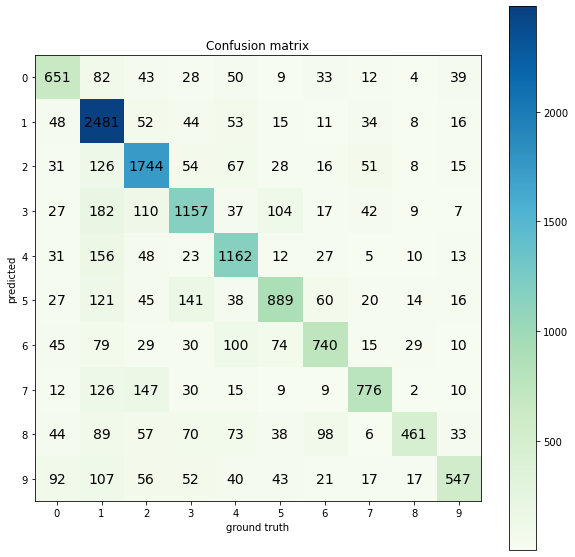

In [15]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    np.add.at(confusion_matrix, [ground_truth, predictions], 1)
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, ground_truth)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

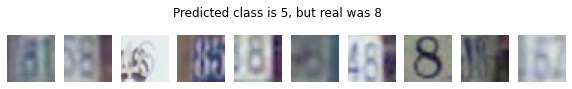

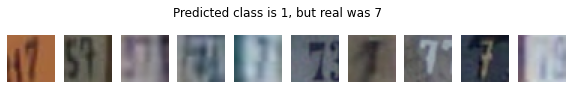

In [17]:
data_train_images = dset.SVHN('../data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!

    title = f'Predicted class is {predicted_class}, but real was {gt_class}'
    indices_to_visualize = val_indices[(predictions == predicted_class) & (groud_truth == gt_class)]
    visualize_images(indices_to_visualize, data, title)

visualize_predicted_actual(5, 8, predictions, ground_truth, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, ground_truth, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [18]:
def return_SGD_optimizer(learing_rate, weight_decay):
  return optim.SGD(nn_model.parameters(), lr=learing_rate, weight_decay=weight_decay)

def return_Adam_optimizer(learing_rate, weight_decay):
  return optim.Adam(nn_model.parameters(), lr=learing_rate, weight_decay=weight_decay)

optimizers = [
    return_SGD_optimizer,
    return_Adam_optimizer
]
optimizers[0](1,2)

SGD (
Parameter Group 0
    dampening: 0
    lr: 1
    momentum: 0
    nesterov: False
    weight_decay: 2
)

In [26]:
# Experiment here!
def return_SGD_optimizer(learing_rate, weight_decay):
  return optim.SGD(nn_model.parameters(), lr=learing_rate, weight_decay=weight_decay)

def return_Adam_optimizer(learing_rate, weight_decay):
  return optim.Adam(nn_model.parameters(), lr=learing_rate, weight_decay=weight_decay)

def return_AdamW_optimizer(learing_rate, weight_decay):
  return optim.AdamW(nn_model.parameters(), lr=learing_rate, weight_decay=weight_decay)

iterations = 10
optimizers = [
    return_SGD_optimizer,
    return_Adam_optimizer,
    return_AdamW_optimizer
]
learning_rates = np.random.uniform(1e-5, 1e-3, 10)
weight_decays = np.random.uniform(1e-3, 1, 10)
hiden_layer_sizes = np.random.random_integers(10,200,10)
epochs = 10
batch_size = 64

loss_hist = []
train_hist = []
val_hist = []

best_val = 0
best_opt = None
best_lr = None
best_weight_decays = None
best_epoch = None

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
lr = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
for iter in range(len(optimizers)):
    print(f"Iteration {iter}")
    nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )
    optimizer = optimizers[iter](1e-3, 1e-2)

    loss_history, train_history, val_history = train_model(nn_model,
                                train_loader, val_loader, loss, optimizer, epochs, lr)
    loss_hist.append(loss_history)
    train_hist.append(train_history)
    val_hist.append(val_history)
    if max(val_history) > best_val:
      best_val = max(val_history)
      best_opt = optimizer
      best_lr = learning_rate
      best_weight_decays = weight_decay
      best_epoch = epoch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: This function is deprecated. Please call randint(10, 200 + 1) instead
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Iteration 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average loss: 1.874188, Train accuracy: 0.393850, Val accuracy: 0.550406
Average loss: 1.428352, Train accuracy: 0.591817, Val accuracy: 0.646850
Average loss: 1.220417, Train accuracy: 0.661605, Val accuracy: 0.688622
Average loss: 1.098995, Train accuracy: 0.691004, Val accuracy: 0.709440
Average loss: 1.014839, Train accuracy: 0.710627, Val accuracy: 0.718313
Average loss: 0.951020, Train accuracy: 0.726342, Val accuracy: 0.731281
Average loss: 0.899129, Train accuracy: 0.738440, Val accuracy: 0.729097
Average loss: 0.856540, Train accuracy: 0.750896, Val accuracy: 0.763907
Average loss: 0.819026, Train accuracy: 0.761304, Val accuracy: 0.772234
Average loss: 0.786720, Train accuracy: 0.768249, Val accuracy: 0.776807
Iteration 1
Average loss: 1.424274, Train accuracy: 0.542863, Val accuracy: 0.611835
Average loss: 1.179836, Train accuracy: 0.632034, Val accuracy: 0.651082
Average loss: 1.141319, Train accuracy: 0.642084, Val accuracy: 0.673742
Average loss: 1.111861, Train accuracy:

In [29]:
print(f"Best val accuracy: {best_val}")

Best val accuracy: 0.8200122858507952


In [30]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print(f"Test accuracy: {test_accuracy}" )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test accuracy: 0.7921020282728949
